In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from IPython.display import display

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
print("hello world")

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


hello world


# Parameters

In [2]:
img_rows, img_cols, img_chns = 20, 20, 3
#img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)
pixel_level_divisor = 16
sample = 8

batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 15))
print("parameters")

parameters


# Load CIFAR10 dataset

In [3]:
# assert img_rows % 2 == 0
assert img_cols % 2 == 0
crop = (32 - img_rows) // 2

ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train[:sample, crop:-crop, crop:-crop, :]
#X_train_out = X_train / 255.
#X_train_out = X_train.copy().reshape((X_train.shape[0], -1))
X_train_out = []
for i in range(img_rows):
    for j in range(img_cols):
        for k in range(img_chns):
            X_train_out.append((X_train[:, i, j, k] // pixel_level_divisor).copy())
# X_train_out = X_train.copy().reshape((X_train.shape[0], -1)) 
#.reshape((X_train.shape[0], -1, 1))
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
#X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
#X_test = np.moveaxis(X_test[:], 1, 3)
#X_test = X_test[:, :img_rows, :img_cols, :]
#X_test_out = []
#for i in range(img_rows):
#    for j in range(img_cols):
#        for k in range(img_chns):
#            X_test_out.append((X_test[:, i, j, k] // pixel_level_divisor).copy())
##X_test_out = X_test.copy().reshape((X_test.shape[0], -1))
##.reshape((X_test.shape[0], -1, 1))
#X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(len(X_train_out))
print(X_train_out[0].shape)
#print(X_test.shape, y_test.shape)
#print(len(X_test_out))
#print(X_test_out[0].shape)

(8, 20, 20, 3) (50000, 1)
1200
(8,)


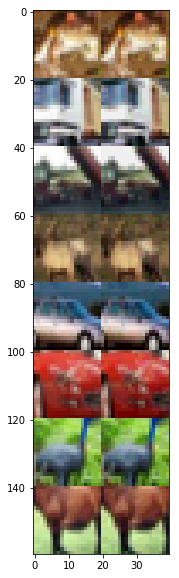

In [4]:
#figure = np.zeros((img_rows * n, img_cols * n * 2, img_chns))
#
#for i in range(n // 2):
#    for j in range(n * 2):
#        orig_img = X_train[i * 2 * n + j] 
#        d_x = (2 * i) * img_rows 
#        d_y = j * img_cols
#        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = orig_img
#        
#        # Digitize
#        img = ((orig_img * 255. // pixel_level_divisor) * pixel_level_divisor).astype(float) / 255
#        figure[d_x + img_rows:d_x + 2 * img_rows, d_y:d_y + img_cols] = img
#        #print(img)

n = min(sample, 10)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    img = ((orig_img * 255. // pixel_level_divisor) * pixel_level_divisor).astype(float) / 255
    figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

In [5]:
class PixelConv2D(Conv2D):
    def __init__(self, ptype, *args, **kwargs):
        # ptype corresponds to pixel type and mask type, e.g. ra, ga, ba, rb, gb, bb
        assert ptype[0] in ['r', 'g', 'b'], ptype
        assert ptype[1] in ['a', 'b'], ptype
        self.ptype = ptype
        super(PixelConv2D, self).__init__(*args, **kwargs)
       
    def build_mask(self, kernel_shape):
        # kernel_shape = kern_dim x kern_dim x total_filters
        #              = kern_dim x kern_dim x r_g_b_filters x filters_per_channel
        assert kernel_shape[0] == kernel_shape[1], "{} must be equal in first two dims".format(kernel_shape)
        assert kernel_shape[0] % 2 == 1, "{} must be odd size in first two dims".format(kernel_shape)
        assert kernel_shape[2] % 3 == 0, "{} must be divisible by 3".format(kernel_shape)
        data = np.ones(kernel_shape)
        
        data.shape
        mid = data.shape[0] // 2
        if self.ptype[0] == 'r':
            filt_prev = 0
            filt_thres = int(data.shape[2] / 3)
        elif self.ptype[0] == 'g':
            filt_prev = int(data.shape[2] / 3)
            filt_thres = int(2 * data.shape[2] / 3)
        else:
            assert self.ptype[0] == 'b', self.ptype
            filt_prev = int(2 * data.shape[2] / 3)
            filt_thres = data.shape[2]
            
        # print(data.shape, self.ptype, mid, filt_prev, filt_thres)
        
        for k1 in range(data.shape[0]):
            for k2 in range(data.shape[1]):
                for chan in range(data.shape[2]):
                    #for filt in range(data.shape[3]):
                    if (self.ptype[1] == 'a' and filt_prev <= chan < filt_thres and k1 == mid and k2 == mid):
                        data[k1, k2, chan, :] = 0
                        #if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
                    elif k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
                        data[k1, k2, chan, :] = 0
            
        return K.constant(np.ravel(data), dtype='float32', shape=kernel_shape)
       
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_mask = self.build_mask(kernel_shape)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        masked_kernel = self.kernel * self.kernel_mask
        outputs = K.conv2d(
            inputs,
            masked_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs

# Model

In [6]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '2a')
    x = conv_block(x, filters2, (3, 3), name=name_base + '2b')
    x = conv_block(x, filters3, (1, 1), name=name_base + '2c')
    x = Add()([x, input_tensor])
    
    return x

def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(filters, kernel_size, name='final' + name + channel_name[channel], padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs_sigmoid(input_tensor, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, channel * in_filters:(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(1, kernel_size, name='output' + name + channel_name[channel], 
                   padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('sigmoid')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs(input_tensor, final_filters):
    outs = []
    for k1 in range(img_rows):
        for k2 in range(img_cols):
            for channel in range(img_chns):
                out = Lambda(lambda x: x[:, k1, k2, channel * final_filters:(channel + 1) * final_filters])(input_tensor)
                out = Dense(256 // pixel_level_divisor, kernel_regularizer=l2(0.001),  bias_regularizer=l2(0.001))(out)
                #out = Dense(256 // pixel_level_divisor)(out)
                outs.append(out)
    #for channel in range(img_chns):
    #    out = Lambda(lambda x: x[:, :, :, channel * final_filters:(channel + 1) * final_filters], axis=-1)(input_tensor)
    #    out = Conv2D(256, (1, 1), name='output' + str(channel) , padding='same')(x)
    #    print(out.shape)
    #    outs.append(out)
    #output = Concatenate()(outs)
    #print(output.shape)
    #output = Flatten()(output)
    #print(output.shape)
                
    return outs

In [7]:
def pixelcnn_loss(target, output):
    # return sparse_categorical_crossentropy(target, output)
    # Note: tf.nn.sparse_softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    # output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    # output = tf.log(output)
    
    # print(target.shape, output.shape)
    # output_shape = output.get_shape()
    targets = tf.cast(target, 'int64')
    targets = tf.reshape(targets, (-1,))
    # logits = tf.reshape(output, [-1, int(output_shape[-1])])
    res = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=output)
    
    return tf.reduce_mean(res)

In [8]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')

final_width = 1000
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
#outputs = build_outputs_sigmoid(x, final_width, 'output_')

#main_output = Concatenate()(outputs)
#main_output = Reshape(original_img_size + (256,))(main_output)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = RMSprop(lr=learning_rate)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
#model.compile(optimizer=optimizer, loss='mse')
model.summary()

Building conv layers...
Building output layers...
Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 20, 20, 3)     0                                            
____________________________________________________________________________________________________
resconv1ra (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ga (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ba (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
_______________________

lambda_521 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_522 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_523 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_524 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_525 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
___________________________________________________________________________________________

____________________________________________________________________________________________________
dense_103 (Dense)                (None, 16)            16016       lambda_109[0][0]                 
____________________________________________________________________________________________________
dense_104 (Dense)                (None, 16)            16016       lambda_110[0][0]                 
____________________________________________________________________________________________________
dense_105 (Dense)                (None, 16)            16016       lambda_111[0][0]                 
____________________________________________________________________________________________________
dense_106 (Dense)                (None, 16)            16016       lambda_112[0][0]                 
____________________________________________________________________________________________________
dense_107 (Dense)                (None, 16)            16016       lambda_113[0][0]        

____________________________________________________________________________________________________
dense_960 (Dense)                (None, 16)            16016       lambda_966[0][0]                 
____________________________________________________________________________________________________
dense_961 (Dense)                (None, 16)            16016       lambda_967[0][0]                 
____________________________________________________________________________________________________
dense_962 (Dense)                (None, 16)            16016       lambda_968[0][0]                 
____________________________________________________________________________________________________
dense_963 (Dense)                (None, 16)            16016       lambda_969[0][0]                 
____________________________________________________________________________________________________
dense_964 (Dense)                (None, 16)            16016       lambda_970[0][0]        

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001 * learning_rate)

#history = model.fit_generator(
#    data_generator(X_train, X_train_out, batch_size),
#    #batch_size=batch_size,
#    epochs=epochs,
#    steps_per_epoch=len(X_train) // batch_size,
#    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
#    validation_data=data_generator(X_test, X_test_out, batch_size),
#    validation_steps=len(X_test) // batch_size,
#    max_queue_size=32,
#    #verbose=2
#)


class MyTQDMNotebookCallback(TQDMNotebookCallback):
    def format_metrics(self, logs):
        metrics = self.params['metrics']
        strings = []
        for i, metric in enumerate(metrics):
            if metric in logs:
                strings.append(self.metric_format.format(name=metric, value=np.mean(logs[metric], axis=None)))
                if i > 3:
                    break
        return self.separator.join(strings)

history = model.fit(
    X_train, X_train_out,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[MyTQDMNotebookCallback(), early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    verbose=0
)


done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

/home/brian/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.704993). Check your callbacks.
  % delta_t_median)



Elapsed:  2955.1754779815674


,loss,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_8_loss,dense_9_loss,...,dense_1192_loss,dense_1193_loss,dense_1194_loss,dense_1195_loss,dense_1196_loss,dense_1197_loss,dense_1198_loss,dense_1199_loss,dense_1200_loss,lr
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,275.000000,275.000000,2.750000e+02,275.000000
mean,499.402771,1.900232,1.428895,1.099207,1.005895,0.761165,0.565140,0.934205,0.601689,0.479913,...,0.510812,0.330773,0.357313,0.456415,0.466051,3.564287e-01,0.670043,0.489505,3.248572e-01,0.000782
std,755.652721,0.099216,0.650666,0.758024,0.595749,0.694993,0.682412,0.806003,0.663291,0.573965,...,0.624339,0.594531,0.596098,0.628618,0.678538,6.160625e-01,0.785595,0.681866,6.596124e-01,0.000292
min,3.407535,1.780247,0.144868,0.002059,0.052883,0.000191,0.000036,0.001123,0.000077,0.000017,...,0.000029,0.000002,0.000001,0.000032,0.000006,7.003540e-07,0.000061,0.000008,8.493655e-07,0.000250
0%,3.407535,1.780247,0.144868,0.002059,0.052883,0.000191,0.000036,0.001123,0.000077,0.000017,...,0.000029,0.000002,0.000001,0.000032,0.000006,7.003540e-07,0.000061,0.000008,8.493655e-07,0.000250
25%,13.496841,1.838980,0.857251,0.326021,0.499051,0.022108,0.002209,0.057628,0.004007,0.000478,...,0.000623,0.000072,0.000080,0.000420,0.000155,3.987977e-05,0.001047,0.000144,1.350005e-05,0.000500
50%,96.570743,1.876419,1.451247,1.208149,0.890872,0.664247,0.210465,0.931641,0.315874,0.243341,...,0.164337,0.002665,0.006150,0.039649,0.035091,3.744794e-03,0.268834,0.051578,5.391094e-04,0.001000
75%,648.108042,1.951198,2.045227,1.771970,1.547154,1.263994,1.048621,1.566451,1.095532,0.809301,...,0.892204,0.364603,0.504959,0.891345,0.754439,4.224762e-01,1.340158,0.874312,3.049228e-01,0.001000
95%,2231.466681,2.008209,2.222719,2.124619,1.843643,1.870796,1.846561,2.177580,1.782462,1.593605,...,1.655080,1.652749,1.607900,1.602775,1.833548,1.606670e+00,2.017421,1.839222,1.587806e+00,0.001000
99%,2532.353854,2.106024,2.469345,2.411072,2.030335,2.083668,2.120022,2.408748,2.153612,1.876576,...,1.875334,1.837227,1.856194,1.796474,2.119047,2.136676e+00,2.266615,2.068377,1.919677e+00,0.001000


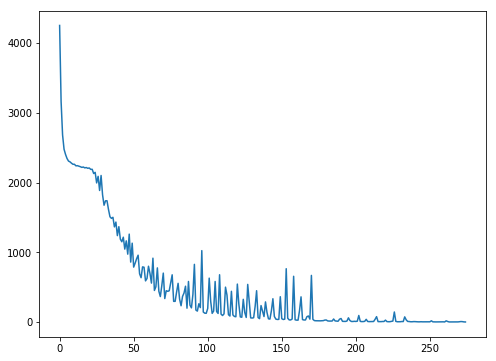

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [11]:
#x_eval_out = []
#for i in range(len(X_train_out)):
#    x_eval_out.append(X_train_out[i])

lossvals = model.evaluate(X_train, X_train_out)
#print(model.metrics_names)
print(lossvals)

8/8 [==============================] - 12s
[3.2341558933258057, 1.7340915203094482, 0.12138661742210388, 0.002802389208227396, 0.04330151900649071, 0.00025979577912949026, 5.803551903227344e-05, 0.0009686980629339814, 7.101374649209902e-05, 1.619728391233366e-05, 0.0005550680216401815, 6.277164357015863e-05, 1.8298171198694035e-05, 0.0008084080182015896, 4.265943425707519e-05, 1.7433874745620415e-05, 0.00012636523752007633, 2.616556957946159e-05, 9.655810572439805e-06, 0.0009162378264591098, 9.47707758314209e-06, 6.228644906514091e-06, 0.0002741186472121626, 1.1443977200542577e-05, 7.957155503390823e-06, 0.004330775700509548, 3.7385842006187886e-05, 8.71710835781414e-06, 0.00020126777235418558, 4.285392424208112e-05, 9.387633326696232e-06, 0.000311718467855826, 3.275152266724035e-05, 1.0177352123719174e-05, 0.0006036227568984032, 2.2798252757638693e-05, 1.0624380593071692e-05, 0.0002076814416795969, 2.136785587936174e-05, 6.183932327985531e-06, 0.0007092218147590756, 1.8775150238070637

(20, 200, 3)


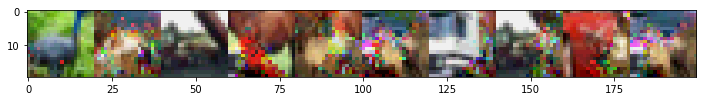

Elapsed:  1285.3904247283936


In [12]:
debug = False

def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                #x_sample[:, i, j, k] = x_out[:, i, j, k]
                index = i * img_cols * img_chns + j * img_chns + k
                for n in range(num_samples):
                    pvals = softmax(x_out[index][n])
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val * pixel_level_divisor / 255.
                    if i == 4 and debug:
                        print("====", i, j, k)
                        print(" pixel_val: ", pixel_val)
                        print(" sample_val: ", x_sample[n, i, j, k])
                        print(" raw: ", x_out[index][n])
                        print(" pvals: ", pvals)
        if debug:
            print("row", i)
        #if i > 5 and debug:
        #    break
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

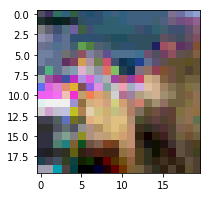

In [13]:

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()


In [14]:
df = pd.DataFrame(samples.reshape(400,3))
df.describe()

,0,1,2
count,400.000000,400.000000,400.000000
mean,0.431216,0.389490,0.390588
std,0.239318,0.183800,0.212993
min,0.000000,0.000000,0.000000
25%,0.250980,0.250980,0.250980
50%,0.376471,0.376471,0.376471
75%,0.564706,0.501961,0.501961
max,0.941176,0.941176,0.941176


In [15]:
#if os.environ.get('OUTDIR', None):
#    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
#    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))
#
#    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
#    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
#        json.dump(vals, f)

In [16]:
#data = np.ones([3, 3, 6, 1])
#
#data.shape
#ptype = 'ba'
#mid = data.shape[0] // 2
#if ptype[0] == 'r':
#    filt_prev = 0
#    filt_thres = int(data.shape[2] / 3)
#elif ptype[0] == 'g':
#    filt_prev = int(data.shape[2] / 3)
#    filt_thres = int(2 * data.shape[2] / 3)
#else:
#    filt_prev = int(2 * data.shape[2] / 3)
#    filt_thres = data.shape[2]
#    
#print(data.shape, ptype, mid, filt_prev, filt_thres)
#
#for k1 in range(data.shape[0]):
#    for k2 in range(data.shape[1]):
#        for chan in range(data.shape[2]):
#            for filt in range(data.shape[3]):
#                if ptype[1] == 'a' and chan >= filt_prev:
#                    if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#                else:
#                    if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#    
#print(data[:, :, 0, 0])
#print(data[:, :, filt_thres-1, 0])
#data



#def data_generator(X_data, X_data_out, batch_size):
#    while True:
#        index = np.arange(len(X_data))
#        np.random.shuffle(index)
#        for i in range(len(X_data) // batch_size):
#            batch_in_data = X_data[index[i * batch_size: (i+1)*batch_size], :, :, :]
#            batch_out_data = X_data_out[index[i * batch_size: (i+1)*batch_size], :, :]
#            yield batch_in_data, to_categorical(batch_out_data, num_classes=256).reshape(batch_size, -1)
#            
#for x, y in data_generator(X_test, X_test_out, 1):
#    print(x.shape, y.shape)
#    break

# Notes

* Did the last conv layer wrong (did a masking layer, when I should have done a 1x1 on each channel) -- actually might want to actually do a type B mask on last layer...
* Debug using single image, then grow it
* GPU small, so cut down problem to 20x20x3; discretize outputs to 16 levels for each channel (vs. 256)
* Found the tensorflow loss function the best, didn't have to duplicate softmax, then call keras, which then converts back to a probability
* Don't need an explicit dense layer on output because loss function takes care of it for me.  Just use output of 1x1 conv directly.
